# Compute the RTP from total-field anomaly data

This code illustrates how to compute the RTP of total-field anomalies.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf

In [3]:
from gravmag import filters, convolve, transforms, eqlayer, data_structures, utils, inverse_distance

### Model

In [4]:
# Create a model formed by prisms
model = {
    'x1' : np.array([  2000.,  1600., -1000.,  -3000.]),
    'x2' : np.array([  3000.,  2600.,  1000.,  -2000.]),
    'y1' : np.array([ -1500., -2500.,   1500., -1000.]),
    'y2' : np.array([  -500., -1500.,   2500.,   3500.]),
    'z1' : np.array([    10.,    10.,     10.,     10.]),
    'z2' : np.array([  1010.,  1010.,   1010.,   1010.])
}

In [5]:
# magnetization of each prism
# first, second and third columns contain
# the magnetization intensity (in A/m), inclination 
# and declination (in degrees) of the sources
h = np.array([1.4, 1.3, 1.1, 1.2])
inc = -45
dec = 50

mx, my, mz = utils.unit_vector(inc, dec)

In [6]:
# arrays with the Cartesian magnetization components of each prism
mx = h * np.broadcast_to(array=mx, shape=(model['x1'].size,))
my = h * np.broadcast_to(array=my, shape=(model['x1'].size,))
mz = h * np.broadcast_to(array=mz, shape=(model['x1'].size,))

In [7]:
# Components of the unit vector defining the
# total-magnetization direction
cos_inc = np.cos(np.deg2rad(inc))
sin_inc = np.sin(np.deg2rad(inc))
cos_dec = np.cos(np.deg2rad(dec))
sin_dec = np.sin(np.deg2rad(dec))
hx_hat = cos_inc*cos_dec
hy_hat = cos_inc*sin_dec
hz_hat = sin_inc

### Points were we compute the synthetic data

In [8]:
# number of points along x and y
shape = (60, 60)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# grid of computation points
coordinates_grid = data_structures.grid_xy(area=area, shape=shape, z0=-150)

# Grid spacing
dx, dy = data_structures.grid_xy_spacing(
    area = coordinates_grid['area'],
    shape = coordinates_grid['shape']
)

In [9]:
# full matrix "views' of the original coordinates in 'coordinates_grid'
X, Y = data_structures.grid_xy_to_full_matrices_view(
    x = coordinates_grid['x'],
    y = coordinates_grid['y'],
    shape = coordinates_grid['shape']
)

### Main field

In [10]:
# reference point
yc, xc = 0, 1000

# polynomial function defining the inclination (degrees)
I0 = 6 - 1e-5*(X-xc) + 3e-4*(Y-yc) + 1e-8*(X-xc)*(X-xc) + 1e-8*(Y-yc)*(Y-yc)

# polynomial function defining the declination (degrees)
D0 = 43 + 6e-5*(X-xc) + 1e-4*(Y-yc) + 3e-9*(X-xc)*(X-xc) + 4e-9*(Y-yc)*(Y-yc)

# polynomial function defining the intensity (nT)
F0 = 23400 + 1e-3*(X-xc) + 1e-3*(Y-yc) + 0*(X-xc)*(X-xc) + 0*(Y-yc)*(Y-yc)

# Cartesian components of the main field
cosI0 = np.cos(np.deg2rad(I0))
sinI0 = np.sin(np.deg2rad(I0))
cosD0 = np.cos(np.deg2rad(D0))
sinD0 = np.sin(np.deg2rad(D0))
Fx = F0*cosI0*cosD0
Fy = F0*cosI0*sinD0
Fz = F0*sinI0

# rearrange the computed field components and angle directions into 1d arrays
I0 = data_structures.grid_xy_full_matrix_to_flatten(grid = I0, ordering = 'xy')
D0 = data_structures.grid_xy_full_matrix_to_flatten(grid = D0, ordering = 'xy')
F0 = data_structures.grid_xy_full_matrix_to_flatten(grid = F0, ordering = 'xy')
Fx = data_structures.grid_xy_full_matrix_to_flatten(grid = Fx, ordering = 'xy')
Fy = data_structures.grid_xy_full_matrix_to_flatten(grid = Fy, ordering = 'xy')
Fz = data_structures.grid_xy_full_matrix_to_flatten(grid = Fz, ordering = 'xy')

In [11]:
# Compute the average main field
mean_I0 = np.mean(I0)
mean_D0 = np.mean(D0)
cos_mean_I0 = np.cos(np.deg2rad(mean_I0))
sin_mean_I0 = np.sin(np.deg2rad(mean_I0))
cos_mean_D0 = np.cos(np.deg2rad(mean_D0))
sin_mean_D0 = np.sin(np.deg2rad(mean_D0))
Fx_mean_hat = cos_mean_I0*cos_mean_D0
Fy_mean_hat = cos_mean_I0*sin_mean_D0
Fz_mean_hat = sin_mean_I0

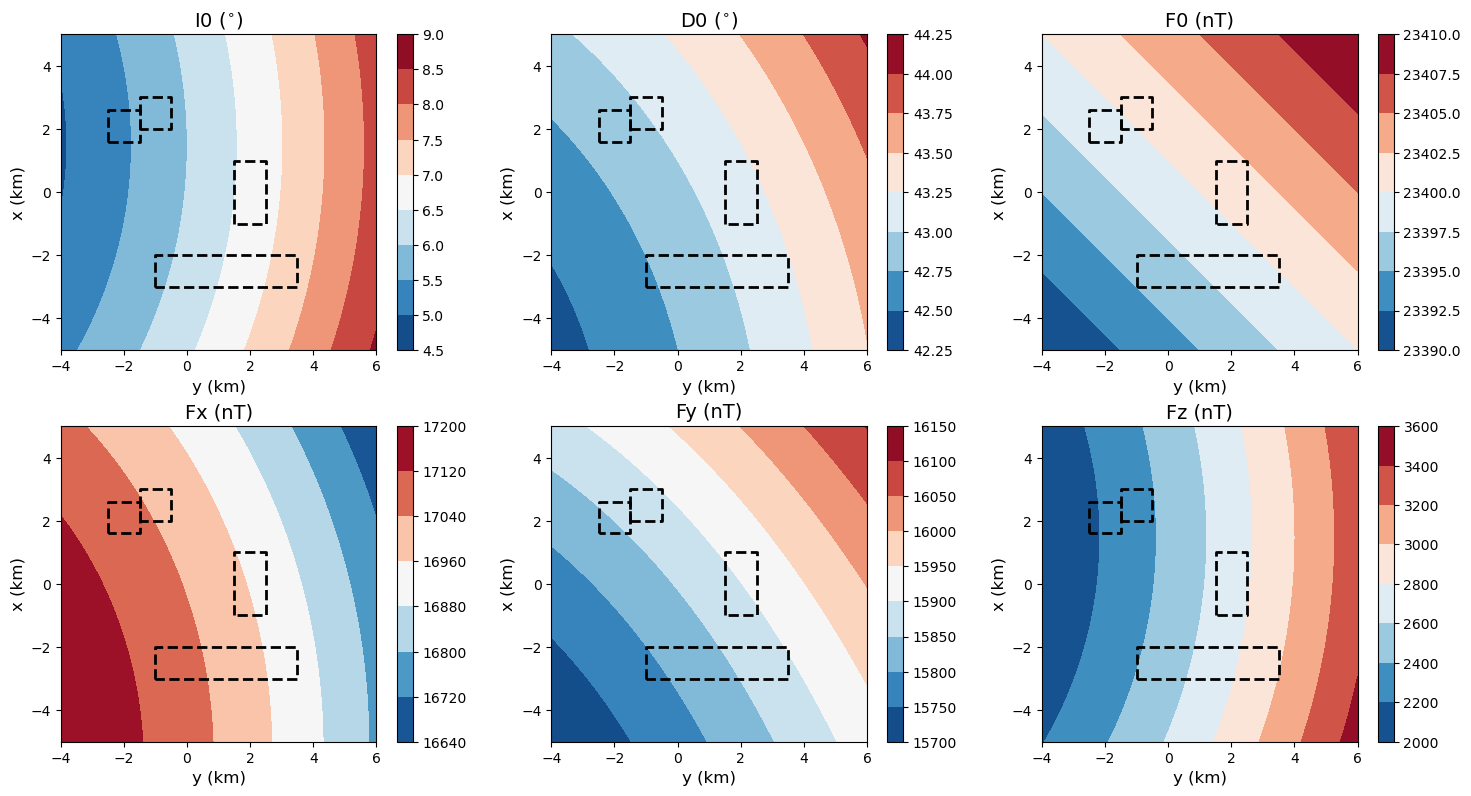

In [12]:
fields = [I0, D0, F0, Fx, Fy, Fz]
windows = [1, 2, 3, 4, 5, 6]
titles = ['I0 ($^{\circ}$)', 'D0 ($^{\circ}$)', 'F0 (nT)',
          'Fx (nT)', 'Fy (nT)', 'Fz (nT)']

plt.figure(figsize=(15,8))

for w, window in enumerate(windows):
    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=fields[w], ordering='xy', shape=coordinates_grid['shape']
        ), 
        cmap='RdBu_r'
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.ylabel('x (km)', fontsize=12)
    plt.xlabel('y (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Synthetic data

In [13]:
# Compute the magnetic field components
bx = rp.mag(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms = model, 
    mx = mx, 
    my = my, 
    mz = mz, 
    field = 'x'
)

by = rp.mag(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms = model, 
    mx = mx, 
    my = my, 
    mz = mz, 
    field = 'y'
)

bz = rp.mag(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms = model, 
    mx = mx, 
    my = my, 
    mz = mz, 
    field = 'z'
)

# Compute the total-field anomaly
tfa = np.sqrt((Fx + bx)**2 + (Fy + by)**2 + (Fz + bz)**2) - F0

# Add a noise to the synthetic data
tfa += np.random.normal(loc=0, scale=5, size=bx.size)

In [14]:
# Compute the "true" RTP anomaly
rtp_anomaly = rp.mag(
    coordinates = data_structures.grid_xy_to_full_flatten(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms = model, 
    mx = np.zeros_like(mx), 
    my = np.zeros_like(my), 
    mz = h, 
    field = 'z'
)

### Plot the total-field and true RTP anomalies

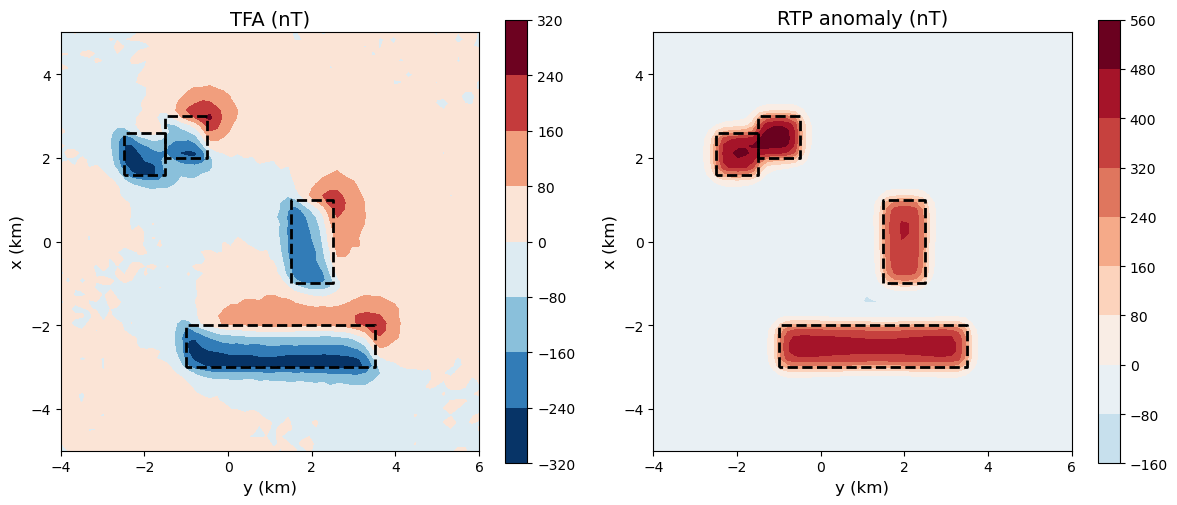

In [15]:
fields = [tfa, rtp_anomaly]
windows = [1, 2]
titles = ['TFA (nT)', 'RTP anomaly (nT)']

plt.figure(figsize=(12,5))

for w, window in enumerate(windows):
    bounds = np.max(np.abs(fields[w]))
    plt.subplot(1,2,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=fields[w], ordering='xy', shape=coordinates_grid['shape']
        ), 
        cmap='RdBu_r', vmin=-bounds, vmax=bounds
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Estimate the RTP anomaly via FFT

In [16]:
# 2D Fourier transform of the TFA with padding
FT_tfa = transforms.DFT(
    data = data_structures.grid_xy_full_flatten_to_matrix(
        data = tfa, ordering = 'xy', shape = coordinates_grid['shape']
    ),
    pad_mode='linear_ramp'
)

# compute the wavenumbers
wavenumbers = data_structures.grid_wavenumbers(
    grid = coordinates_grid,
    pad = True
)

# compute the filter in Fourier domain
rtp_filter = filters.rtp(wavenumbers, mean_I0, mean_D0, inc, dec)

# compute the RTP anomaly in Fourier domain
FT_rtp_fourier = convolve.compute(FT_data = FT_tfa, filters = [rtp_filter])

# 2D Inverse Fourier transform of the convolved data
rtp_fourier = data_structures.grid_xy_full_matrix_to_flatten(
    grid = transforms.IDFT(FT_rtp_fourier, unpad=True), 
    ordering = 'xy'
)

### Estimate the RTP anomaly via equivalent-layer technique

In [17]:
# layer z
z_layer = coordinates_grid['z'] + 2.5*(0.5*(dx+dy))

In [23]:
# compute the eigenvalues matrix
R2 = inverse_distance.sedm_BTTB(
    data_grid = coordinates_grid, 
    delta_z = z_layer - coordinates_grid['z'],
    ordering = 'xy'
)

Directional_derivative = inverse_distance.directional_2nd_order_BTTB(
    data_grid = coordinates_grid,
    delta_z = z_layer - coordinates_grid['z'],
    SEDM = R2,
    ordering = 'xy',
    inc0 = mean_I0,
    dec0 = mean_D0,
    inc = inc,
    dec= dec
)

L = []
for component in ['xx', 'xy', 'xz', 'yy', 'yz']:
    L.append(
        convolve.eigenvalues_BCCB(
            BTTB_metadata=Directional_derivative[component], 
            ordering="row"
        )
    )
L = np.sum(L, axis=0)

In [25]:
L.shape

(120, 120)

In [26]:
# estimate the equivalent layer
deltas, parameters = eqlayer.method_iterative_deconvolution_TOB20(
    eigenvalues_matrices = [L], 
    data_vectors = [tfa], 
    epsilon = 1e-5, 
    ITMAX = 50, 
    p0 = None
)

In [27]:
iterations = [i for i in range(len(deltas))]

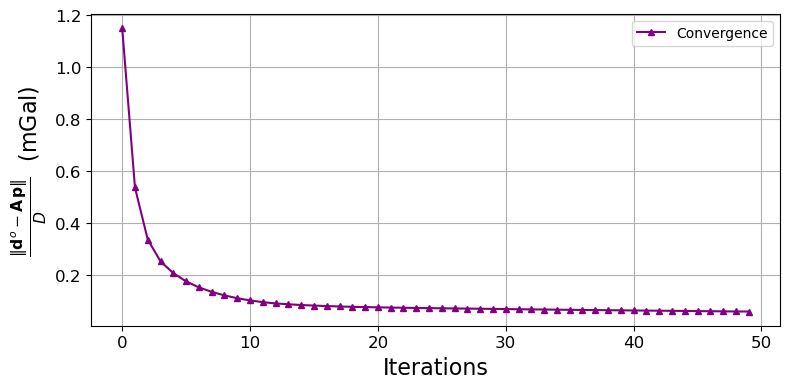

In [28]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(iterations, deltas, linestyle='-', 
        color='purple', marker='^', alpha=1, markersize=4, label='Convergence')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('Iterations', fontsize=16)
ax.set_ylabel('$\\frac{\Vert \mathbf{d}^{o} - \mathbf{A} \, \mathbf{p} \Vert}{D}$  (mGal)', fontsize=16)
ax.grid(True)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

In [29]:
# data predicted by the estimated equivalent layer
tfa_eql = convolve.product_BCCB_vector(
    eigenvalues=L, ordering="row", v=parameters
)

In [32]:
# eigenvalues matrix associated with the RTP
G = inverse_distance.grad_tensor_BTTB(
    data_grid = coordinates_grid,
    delta_z = z_layer - coordinates_grid['z'],
    SEDM = R2,
    ordering = 'xy',
    components = ['zz']
)['zz']

L_rtp = convolve.eigenvalues_BCCB(
    BTTB_metadata=G, 
    ordering="row"
)

In [33]:
# total-field anomaly predicted by the estimated equivalent layer
rtp_eql = convolve.product_BCCB_vector(
    eigenvalues=L_rtp, ordering="row", v=parameters
)

### Plot the results

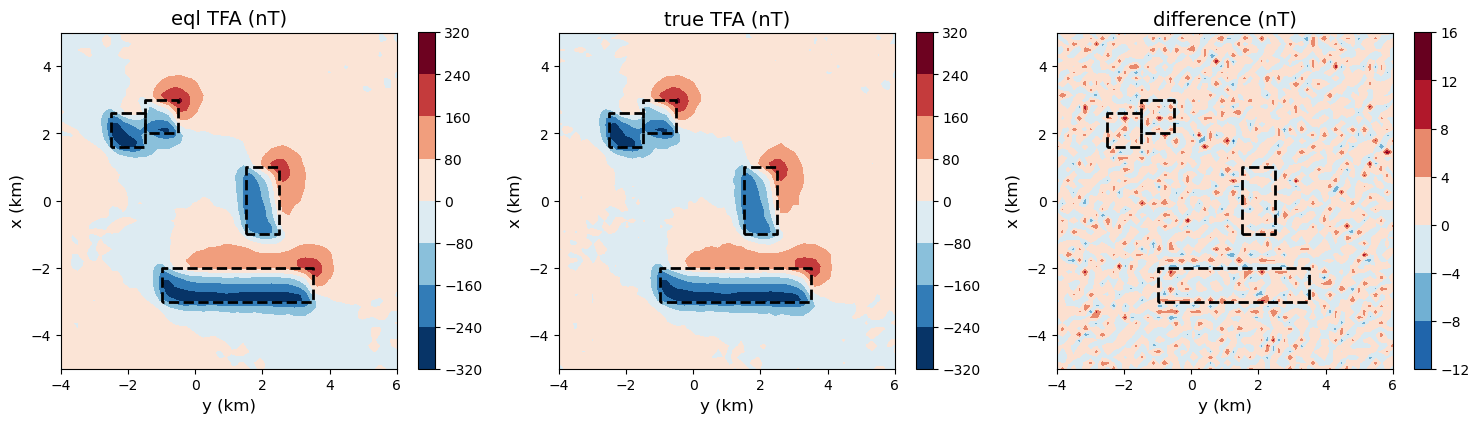

In [34]:
field_names = ['TFA']
field_units =['nT']

true_fields = [tfa]

predicted_fields = [tfa_eql]

bounds, diffs = plf.bounds_diffs(predicted_fields, true_fields)

fields = plf.fields_list(predicted_fields, true_fields, diffs)

titles = []
for name, unit in zip(field_names, field_units):
    titles.append('eql {} ({})'.format(name,unit))
    titles.append('true {} ({})'.format(name,unit))
    titles.append('difference ({})'.format(unit))

windows = [i for i in range(1,4)]

plt.figure(figsize=(15,4))

for w, window in enumerate(windows):

    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=fields[w], ordering='xy', shape=coordinates_grid['shape']
        ), 
        cmap='RdBu_r', vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

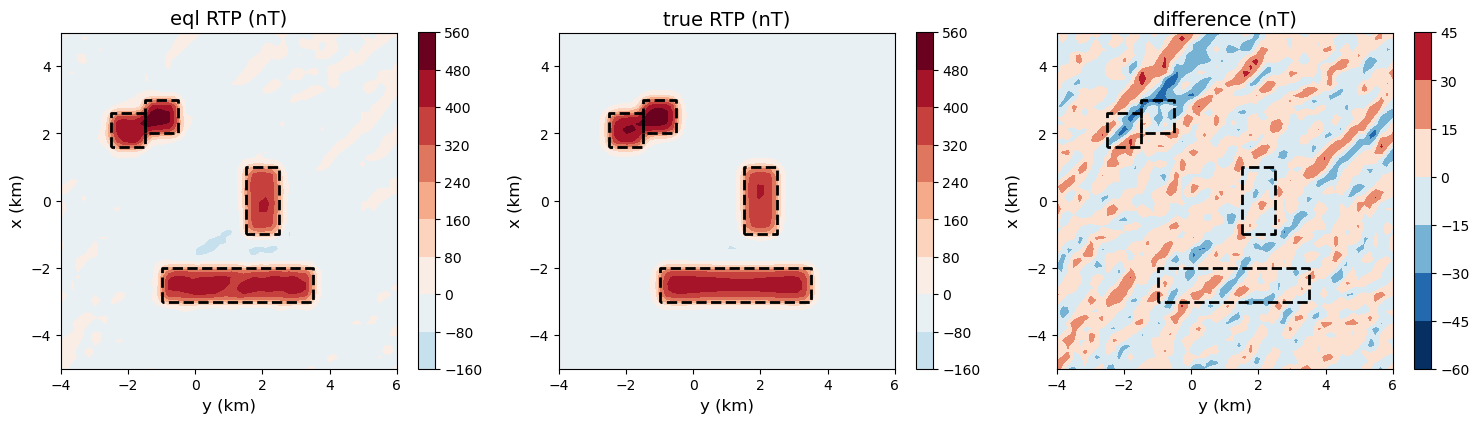

In [35]:
field_names = ['RTP']
field_units =['nT']

true_fields = [rtp_anomaly]

predicted_fields = [rtp_eql]

bounds, diffs = plf.bounds_diffs(predicted_fields, true_fields)

fields = plf.fields_list(predicted_fields, true_fields, diffs)

titles = []
for name, unit in zip(field_names, field_units):
    titles.append('eql {} ({})'.format(name,unit))
    titles.append('true {} ({})'.format(name,unit))
    titles.append('difference ({})'.format(unit))

windows = [i for i in range(1,4)]

plt.figure(figsize=(15,4))

for w, window in enumerate(windows):
    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=fields[w], ordering='xy', shape=coordinates_grid['shape']
        ), 
        cmap='RdBu_r', vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

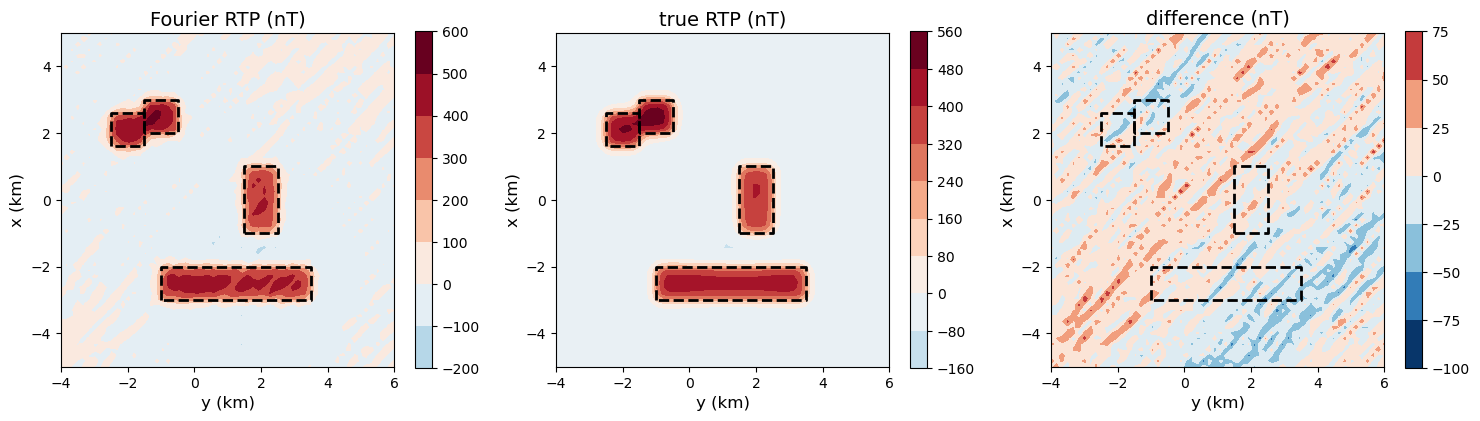

In [36]:
field_names = ['RTP']
field_units =['nT']

true_fields = [rtp_anomaly]

predicted_fields = [rtp_fourier]

bounds, diffs = plf.bounds_diffs(predicted_fields, true_fields)

fields = plf.fields_list(predicted_fields, true_fields, diffs)

titles = []
for name, unit in zip(field_names, field_units):
    titles.append('Fourier {} ({})'.format(name,unit))
    titles.append('true {} ({})'.format(name,unit))
    titles.append('difference ({})'.format(unit))

windows = [i for i in range(1,4)]

plt.figure(figsize=(15,4))

for w, window in enumerate(windows):

    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        data_structures.grid_xy_full_flatten_to_matrix(
            data=fields[w], ordering='xy', shape=coordinates_grid['shape']
        ), 
        cmap='RdBu_r', vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()